In [1]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
import random
mndata = MNIST('/home/shoachia/Documents/CSE250B/mnist')

In [2]:
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images) 
test_labels = np.array(test_labels)

## Check the mnist data distribution (whether balanced)

In [3]:
def distribution(train_L,N):
    train_dis = np.zeros((N,1))
    for num in range (len(train_L)):
        train_dis[train_L[num]] += 1
    return train_dis

In [4]:
ori_dis = distribution(train_labels,10)
print(ori_dis)

[[5923.]
 [6742.]
 [5958.]
 [6131.]
 [5842.]
 [5421.]
 [5918.]
 [6265.]
 [5851.]
 [5949.]]


## 1-NN 

In [5]:
# 1-NN brute-force
def KNN (train_I, train_L,test_I):
    test_L = np.zeros((len(test_I),1))
    for i in range(len(test_I)):
        dist = np.sum(np.power(train_I - test_I[i],2),axis = 1)
        # finding the argmin --> ignore doing sqrt to save some time
        idx = np.argmin(dist)
        test_L[i] = train_L[idx]
    return test_L

In [6]:
# Caculate the error rate 
def err(pre,test_L):
    all_set = distribution(test_L,10)
    prob = all_set / len(test_L)
    #print(all_set)
    each_err = distribution(test_L,10)
    for i in range(len(pre)):
        if pre[i] != test_L[i]:
            each_err[test_L[i]] -= 1
    #print(each_err)
    each_err = (all_set - each_err) / all_set
    all_err = np.sum(each_err * prob)
    return each_err, all_err

In [7]:
from sklearn.neighbors import KNeighborsClassifier
def built_KNN(train_I, train_L,test_I):
    neigh = KNeighborsClassifier(n_neighbors = 1)
    neigh.fit(train_I, train_L)
    return neigh.predict(test_I)

## Random Selection Data Size Reduction

In [8]:
def randselect(train_I,train_L,M):
    rand_idx = random.sample(range(0, len(train_L)), M)
    rand_idx = sorted(rand_idx)
    ret_L = np.reshape(train_L[rand_idx],(M,1)) 
    return train_I[rand_idx], ret_L

In [9]:
for times in range(5):
    train_images_rand, train_labels_rand = randselect(train_images,train_labels,5000)
    predict_rand = built_KNN(train_images_rand,train_labels_rand,test_images)
    error_rate_rand, all_error_rate_rand = err(predict_rand,test_labels)
    #print(error_rate_rand)
    print(all_error_rate_rand)

/home/shoachia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


0.0652
0.0659
0.0643
0.0664
0.0628


### Random selection

#### M = 500
* 0.1461
* 0.1516
* 0.1610
* 0.1618 
* 0.1494
---
* 0.1539

#### M = 800

* 0.1257
* 0.1272
* 0.1272
* 0.1294
* 0.1274
---
* 0.12738

#### M = 1000

* 0.1139
* 0.1220
* 0.1187
* 0.1138
* 0.1167
---
* 0.1170

#### M = 2000

* 0.0879
* 0.0936
* 0.0888
* 0.0871
* 0.0876
---
* 0.0890

#### M = 5000

* 0.0640
* 0.0639
* 0.0615
* 0.0651
* 0.0654
---
* 0.06398

#### M = 10000
* 0.05490
* 0.05289
* 0.0543
* 0.0511
* 0.0533
---
* 0.05329

## Prototype selection of Data

### k means


In [10]:
from sklearn.cluster import KMeans

# sorted the dataset to be from label 9 to label 0
train_labels_inds = train_labels.argsort()
sorted_train_labels = train_labels[train_labels_inds[::1]]
sorted_train_images = train_images[train_labels_inds[::1]]

In [11]:
def randompick (train_I,M):
    rand_idx = random.sample(range(0, len(train_I)), M)
    rand_idx = sorted(rand_idx)
    return train_I[rand_idx]

In [12]:
def mean_sur (train_I,M):
    mean_feature = np.mean(train_I,axis = 0)
    dist = np.sum(np.power(train_I - mean_feature,2), axis = 1)
    idx = dist.argsort()
    return train_I[idx[0:M]]

In [13]:
def get_new_data(sort_labels,sort_images,M,N):
    ret_images = np.zeros((M,784))
    ret_labels = np.zeros((M,1))
    pick = (int)(M/(10*N))
    for j in range(10):
        for p in range((int)(M/10)):
            ret_labels[(int)(j*(M/10)+p)] = j
    class_dis = distribution(sort_labels,10)
    # choose points from each class
    cnt = 0
    start = 0
    end = 0
    for c in range(10):
        end += (int)(class_dis[c])
        #get the array in each class
        tmp_images = sort_images[start:end]
        kmeans_tmp = KMeans(n_clusters = N, random_state=0).fit(tmp_images)
        tmp_labels = kmeans_tmp.labels_
        tmp_labels_idx = tmp_labels.argsort()
        sort_tmp_labels = tmp_labels[tmp_labels_idx[::1]]
        sort_tmp_images = tmp_images[tmp_labels_idx[::1]]
        tmp_dis = distribution(sort_tmp_labels,N)
        #print(tmp_dis)
        start = end
        small_start = 0
        small_end = 0
        for small_class in range(N):
            small_end += (int)(tmp_dis[small_class]) 
            # get the array in each small class
            small_tmp_images = sort_tmp_images[small_start:small_end]
            #print(np.shape(small_tmp_images))
            
            ## Maybe should pick the points that sorrounded the mean point
            ret_images[cnt:cnt+pick] = mean_sur(small_tmp_images,pick)
            ret_labels[cnt:cnt+pick] = np.full((pick,1),c)
            cnt += pick
            small_start = small_end
    # To complement the needed data
    if cnt < M:
        ret_images[cnt:M],ret_labels[cnt:M] = randselect(sort_images,sort_labels,M-cnt)
        
    return ret_images, ret_labels

In [14]:
for t in range(5):
    red_images, red_labels = get_new_data(sorted_train_labels,sorted_train_images,5000,15) 
    predict_kmeans = built_KNN(red_images,red_labels,test_images)
    error_rate_kmeans, all_err_rate_kmeans = err(predict_kmeans,test_labels)
    #print(error_rate_kmeans)
    print(all_err_rate_kmeans)

/home/shoachia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


0.063
0.0635
0.0632
0.0635
0.0624


### My Selection

#### M = 500
* 0.09890
* 0.09980
* 0.09800
* 0.09830
* 0.09970
---
* 0.09894

#### M = 800
* 0.08889
* 0.08940
* 0.08830
* 0.08740
* 0.08880
---
* 0.08855

#### M = 1000

* 0.08499
* 0.08429
* 0.08630
* 0.08480
* 0.08800
--------------
* 0.08567

#### M = 2000

* 0.07390
* 0.07570
* 0.07400
* 0.07360
* 0.07370
---
* 0.07418

#### M = 5000

* 0.063
* 0.0635
* 0.0632
* 0.0635
* 0.0624
---
* 0.0631

#### M = 10000

* 0.0563
* 0.0563
* 0.0564
* 0.0565
* 0.0556
---
* 0.05622


In [15]:
import matplotlib.pyplot as plt

[3.]


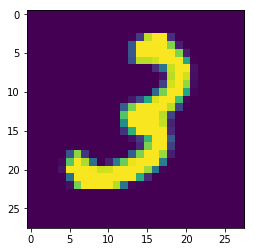

In [16]:
X = 1504
plt.imshow(np.reshape(red_images[X],(28,28)))
print(red_labels[X])

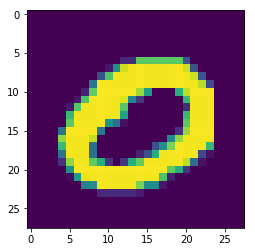

In [17]:
plt.imshow(np.reshape(red_images[41],(28,28)))